In [1]:
import pandas as pd
import numpy as np
import talib
from utils import utils
import os
%matplotlib inline

In [2]:
df = pd.read_csv('../data/USDJPY.csv')
df.sample(5)

,Gmt time,Open,High,Low,Close,Volume
95994,12.09.2018 13:00:00.000,111.301,111.362,111.266,111.287,7292.7500
100482,04.06.2019 03:00:00.000,107.988,108.041,107.984,108.004,7766.4102
36564,06.03.2009 03:00:00.000,98.160,98.215,98.045,98.205,19047.4004
2540,30.09.2003 03:00:00.000,111.060,111.152,111.021,111.074,14275.0000
1342,21.07.2003 20:00:00.000,118.556,118.577,118.359,118.485,22878.5000


In [3]:
df = utils.rename_columns_and_format(df)
df = utils.get_all_indicators(df)

df.dropna(inplace=True)
df.head()

,date,open,high,low,close,volume,rsi,ema_12,ema_26,upper_bband,middle_bband,lower_bband,macd,macd_signal,macd_hist,k,d
33,2003-01-08 06:00:00,120.436,120.687,120.331,120.596,11794.4004,69.010347,120.132198,119.921418,120.788292,119.79655,118.804808,0.211636,0.067038,0.144598,45.716382,50.669477
34,2003-01-08 07:00:00,120.572,120.656,120.347,120.407,10637.4004,62.713588,120.174475,119.957387,120.857165,119.83185,118.806535,0.217813,0.097193,0.120620,52.899983,48.448860
35,2003-01-08 08:00:00,120.404,120.632,120.324,120.508,12336.2002,64.573838,120.225787,119.998173,120.936120,119.87120,118.806280,0.228226,0.123399,0.104827,56.862745,51.826370
36,2003-01-08 09:00:00,120.538,120.584,120.235,120.319,13210.7002,58.674600,120.240127,120.021938,120.981654,119.90550,118.829346,0.218708,0.142461,0.076247,36.861357,48.874695
37,2003-01-08 10:00:00,120.316,120.567,120.273,120.496,12268.0996,62.160985,120.279492,120.057054,121.043257,119.95620,118.869143,0.222877,0.158544,0.064333,44.736596,46.153566


## Prueba utilizando indicadores individuales como inputs

In [4]:
WINDOW = 30
P_TRAIN = 0.8
EPOCHS = 100
BATCH_SIZE = 32

### Hacemos un head 500 pq solo es para pruebas

In [5]:
df = df.head(500)

In [6]:
columns = ['ema_12', 'ema_26', 'upper_bband', 
         'middle_bband', 'lower_bband', 'rsi', 
         'macd', 'macd_signal', 'macd_hist', 'k', 'd']

target_column = df['close'].to_numpy()
for column in columns:
    df_min = df[column]
    x, y = utils.create_windowed_dataset(df_min, target_column, WINDOW)
    x_train, x_test, y_train, y_test = utils.train_test_split(P_TRAIN, x, y)
    
    _, x_input, y_input = x.shape
    model = utils.get_model(x_input, y_input)
    
    x_train = np.expand_dims(x_train, axis=3)
    x_test = np.expand_dims(x_test, axis=3)
    
    history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_test,y_test), 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    verbose=0)
    
    df_history = pd.DataFrame(history.history)
    df_history.to_csv(f'../metrics/{column}_performance.csv', index=False) 

In [7]:
df_metrics = pd.DataFrame(columns=['loss','val_loss', 'root_mean_squared_error','val_root_mean_squared_error'])

files = os.listdir('../metrics')
for file in files:
    input_name = file
    
    path = os.path.join('../metrics', file)
    df_metric = pd.read_csv(path)
    
    df_metrics = df_metrics.append(df_metric.iloc[-1])

files = [f.split('.csv')[0] for f in files]
df_metrics.index = files
df_metrics.sort_values(by=['val_root_mean_squared_error'])


,loss,val_loss,root_mean_squared_error,val_root_mean_squared_error
macd_hist_performance,1401.655218,135.583966,37.438690,11.644053
macd_signal_performance,1063.984359,155.663793,32.618774,12.476529
lower_bband_performance,1059.670931,265.803229,32.552589,16.303473
rsi_performance,1229.611259,276.489229,35.065811,16.627966
macd_performance,1556.731931,326.173140,39.455444,18.060265
middle_bband_performance,1097.568309,421.273299,33.129570,20.524944
ema_26_performance,1034.294318,516.109796,32.160446,22.718050
ema_12_performance,1184.861570,579.480706,34.421818,24.072405
d_performance,1332.128404,664.664304,36.498337,25.781084
upper_bband_performance,1272.148895,711.155723,35.667198,26.667503


In [8]:
#grafico de barras con la performance de c/u

## Prueba utilizando todos los indicadores

In [9]:
df_min = df[columns]

x, y = utils.create_windowed_dataset(df_min, df['close'].to_numpy(), WINDOW)
x_train, x_test, y_train, y_test = utils.train_test_split(P_TRAIN, x, y)

_, x_input, y_input = x.shape
model = utils.get_model(x_input, y_input)

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

history = model.fit(x_train, 
                y_train, 
                validation_data=(x_test,y_test), 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS,
                verbose=0)

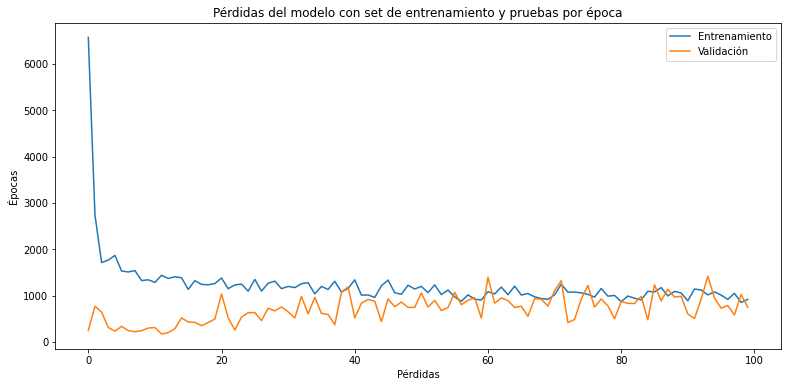

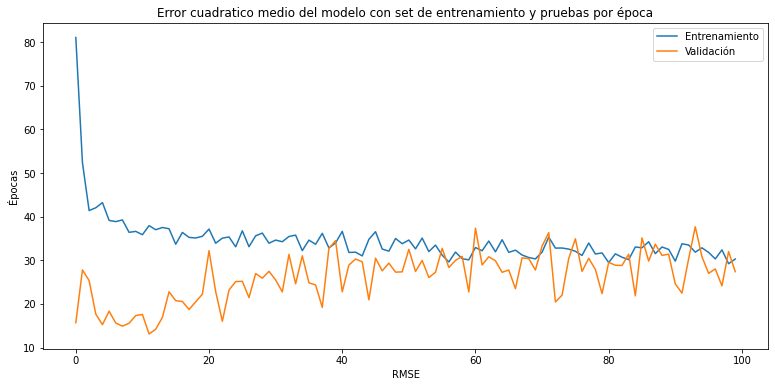

In [10]:
x1 = model.history.history['loss']
x2 = model.history.history['val_loss']
title = "Pérdidas del modelo con set de entrenamiento y pruebas por época"
ylabel = 'Pérdidas'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

x1 = model.history.history['root_mean_squared_error']
x2 = model.history.history['val_root_mean_squared_error']
title = "Error cuadratico medio del modelo con set de entrenamiento y pruebas por época"
ylabel = 'RMSE'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

## Prueba utilizando los indicadores de tipo oscilador 

In [11]:
columns = ['rsi', 'macd', 'macd_signal', 'macd_hist', 'k', 'd']

df_min = df[columns]

x, y = utils.create_windowed_dataset(df_min, df['close'].to_numpy(), WINDOW)
x_train, x_test, y_train, y_test = utils.train_test_split(P_TRAIN, x, y)

_, x_input, y_input = x.shape
model = utils.get_model(x_input, y_input)

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

history = model.fit(x_train, 
                y_train, 
                validation_data=(x_test,y_test), 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS,
                verbose=0)

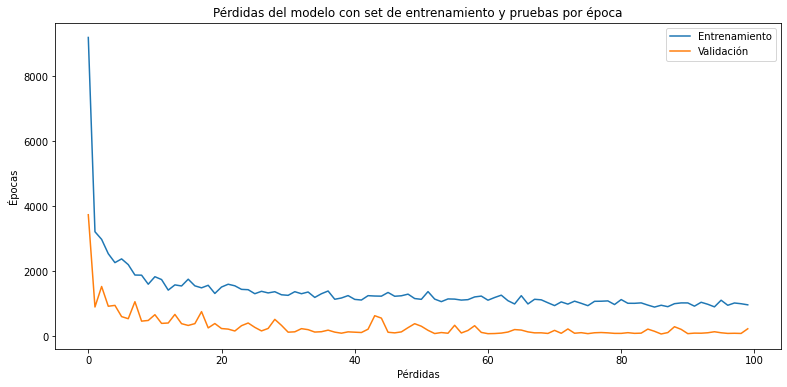

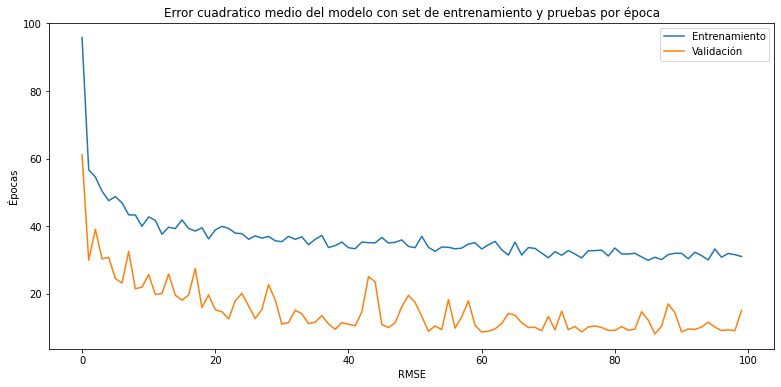

In [12]:
x1 = model.history.history['loss']
x2 = model.history.history['val_loss']
title = "Pérdidas del modelo con set de entrenamiento y pruebas por época"
ylabel = 'Pérdidas'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

x1 = model.history.history['root_mean_squared_error']
x2 = model.history.history['val_root_mean_squared_error']
title = "Error cuadratico medio del modelo con set de entrenamiento y pruebas por época"
ylabel = 'RMSE'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

## Prueba utilizando solo los indicadores de tendencia

In [13]:
columns = ['ema_12', 'ema_26', 'upper_bband', 
         'middle_bband', 'lower_bband']

df_min = df[columns]

x, y = utils.create_windowed_dataset(df_min, df['close'].to_numpy(), WINDOW)
x_train, x_test, y_train, y_test = utils.train_test_split(P_TRAIN, x, y)

_, x_input, y_input = x.shape
model = utils.get_model(x_input, y_input)

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

history = model.fit(x_train, 
                y_train, 
                validation_data=(x_test,y_test), 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS,
                verbose=0)

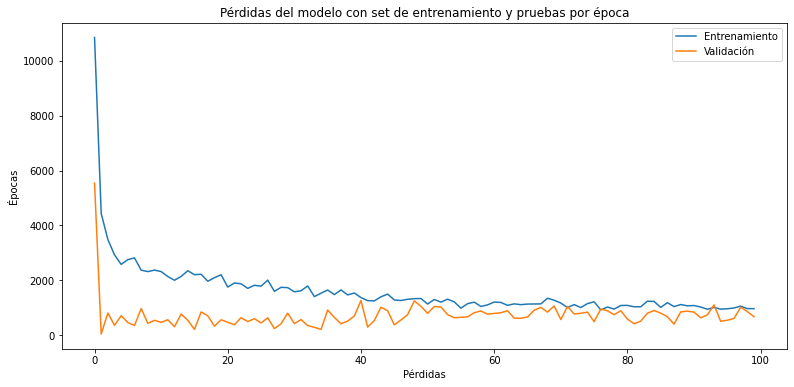

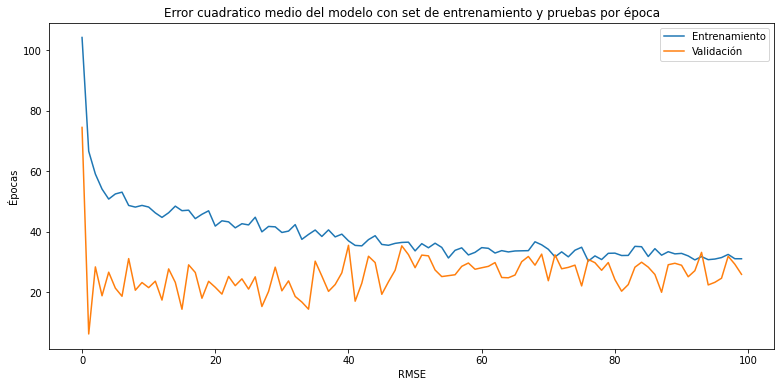

In [14]:
x1 = model.history.history['loss']
x2 = model.history.history['val_loss']
title = "Pérdidas del modelo con set de entrenamiento y pruebas por época"
ylabel = 'Pérdidas'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)

x1 = model.history.history['root_mean_squared_error']
x2 = model.history.history['val_root_mean_squared_error']
title = "Error cuadratico medio del modelo con set de entrenamiento y pruebas por época"
ylabel = 'RMSE'
xlabel = 'Épocas'
legend = ['Entrenamiento', 'Validación']
utils.plot(x1, x2, title, xlabel, ylabel, legend)